In [1]:
import re
import sys
import os
import math

import spacy

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import coreferee

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

from relationships import referee, to_archetype, get_relationships, graph_similarity

os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

%matplotlib inline

In [2]:
interact = Interact(load_config())

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.627s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.072s]
POST https://tachikoma1.persyn.io:9200/anna-entities-v0/_search [status:200 duration:0.065s]
POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.129s]
POST https://tachikoma1.persyn.io:9200/anna-opinions-v0/_search [status:200 duration:0.067s]
POST https://tachikoma1.persyn.io:9200/anna-beliefs-v0/_search [status:200 duration:0.069s]


In [3]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('coreferee')
nlp.add_pipe('sentencizer')

In [4]:
def show_fig(G, edge_labels=None, summary='', seed=3):
    if G.order() == 0:
        return
 
    if edge_labels is None:
        edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

    plt.figure(figsize=(24, 12))
    # pos = nx.spring_layout(G, k=5/math.sqrt(G.order()), seed=seed, iterations=50, weight=None)
    pos = nx.circular_layout(G)
    
    sources = [n for n in G.nodes() if G.in_degree(n)==0]
    targets = [n for n in G.nodes() if G.out_degree(n)==0]
    others = [n for n in G.nodes if G.out_degree(n) and G.in_degree(n)]

    nx.draw_networkx_edges(G, pos, edge_color='#c0c0c0', arrowsize=50)

    nx.draw_networkx_nodes(G, pos, nodelist=others, node_color='#aaaaaa', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=sources, node_color='#fc8d62', node_size=1000)
    nx.draw_networkx_nodes(G, pos, nodelist=targets, node_color='lightblue', node_size=1000)

    nx.draw_networkx_labels(G, pos, font_color='black', font_size=18)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, font_color='black', rotate=True, clip_on=False)


    plt.axis('off')
    plt.title(summary)
    plt.show()

In [5]:
ret = interact.recall.ltm.es.search(
    index='anna-conversations-v0', 
    # query={"term": {"channel.keyword": {"value": channel}}},
    query={"match_all": {}},
    aggs={"convo_id":{"terms" : { "field" : "convo_id.keyword" }}},
    size=1000
)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.726s]


In [6]:
convo_ids = set()
for hit in ret['hits']['hits']:
    convo_ids.add(hit['_source']['convo_id'])

In [7]:
len(convo_ids)

197

In [ ]:
for convo_id in tqdm(convo_ids):
    convo = interact.recall.ltm.get_convo_by_id(convo_id)

    src = { 'summary': '(no summary available)' }

    try:
        summary = interact.recall.ltm.es.search(
            index='anna-summaries-v0', 
            query={"term": {"convo_id.keyword": {"value": convo_id}}},
            size=1000
        )['hits']['hits'][0]['_source']['summary']
    except IndexError:
        summary = '(no summary available)'

    print(f'convo_id: {convo_id}, {len(convo)} lines')

# All summaries from this channel from the beginning of time
# interact.recall.load(service, channel, summaries=100)

    speakers = set() # set(['hackerfriendly'])
    convo_lines = []
    for c in convo:
        src = c['_source']
        # Only process dialog
        if src['speaker'].endswith('recalls') or 'remembers' in src['speaker']:
            continue

        speakers.add(src['speaker'])

        for line in [str(s) for s in nlp(src['msg']).sents]:
            persons = []

            # Sub speaker for 'I'. Spacy should really handle this.
            line = re.sub(r"\bI'[m|d]\b", f"{src['speaker']} be", line)
            line = re.sub(r"\bI've\b", f"{src['speaker']} have", line)
            line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)

            # sent = nlp(line)

            convo_lines.append(line)

        relations = []
        # for i, s in enumerate(tqdm([s for s in [referee(to_archetype(s)) for s in convo_lines]])):
        for i, s in enumerate([r for r in [referee(to_archetype(s)) for s in convo_lines]]):
            rels = get_relationships(s)
            if rels:
                relations.append(rels)

        rels = get_relationships(referee(to_archetype(summary)))
        if rels:
            relations.append(rels)

        # collapse left and right.
        the_rels = [(' '.join(rel['left']).strip(), ' '.join(rel['right']).strip(), {'edge': rel['rel']}) for relation in relations for rel in relation]

        G = nx.from_edgelist(the_rels, create_using=nx.DiGraph)
                
        doc = {
            '@timestamp': src['@timestamp'],
            'service': src['service'],
            'channel': src['channel'],
            'convo_id': src['convo_id'],
            'graph': nx.node_link_data(G),
            'convo': ' '.join(convo_lines),
            'refresh': False
        }

        assert interact.recall.ltm.save_relationship(**doc)['result'] == 'created'
        
        # G_edge_labels = dict([((n1, n2), n3['edge'] if n3['edge'] != 'punct' else '') for n1, n2, n3 in G.edges(data=True)])        
        # show_fig(G, G_edge_labels, summary, seed=23)
    

# A single unified graph

In [40]:
from operator import itemgetter

In [ ]:
graphs = []
for convo_id in convo_ids:
    ret = interact.recall.ltm.es.search(index='anna-conversations-v0', query={"match": {"convo_id": convo_id}}, size=1)
    service, channel = itemgetter('service', 'channel')(ret['hits']['hits'][0]['_source'])
    ret = interact.recall.ltm.lookup_relationship(service, channel, convo_id=convo_id)
    if ret:
        graphs.append(nx.node_link_graph(ret[0]['_source']['graph']))

In [57]:
len(graphs)

141

In [58]:
G = nx.compose_all(graphs)

In [68]:
with open('/home/rob/out.cys', 'w') as f:
    f.write(json.dumps(nx.cytoscape_data(G)))

# Graph comparison tests

In [51]:
def rfind(query, size=10):
    return interact.recall.ltm.es.search(index='anna-relationships-v0', query={"match": {"convo": query}}, size=size)['hits']['hits']

In [52]:
def build_graph(text):
    doc = nlp(text)

    relations = []
    for i, s in enumerate([r for r in [referee(to_archetype(str(s))) for s in doc.sents]]):
        rels = get_relationships(s)
        if rels:
            relations.append(rels)

    # collapse left and right.
    the_rels = [(' '.join(rel['left']).strip(), ' '.join(rel['right']).strip(), {'edge': rel['rel']}) for relation in relations for rel in relation]

    return nx.from_edgelist(the_rels, create_using=nx.DiGraph)

In [53]:
def load_graph(hit):
    ''' Load an nx graph from an ES hit '''    
    return nx.node_link_graph(hit['_source']['graph'])

In [54]:
def best_match(G, hits, edge_bias=1):
    match = {}
    for hit in hits:
        gh = load_graph(hit)
        match[graph_similarity(G, gh, edge_bias)] = hit

    for m in match:
        print(round(m, 4), match[m]['_source']['convo'][:100])
        
    print('\n', "BEST SCORE:", max(match), match[max(match)]['_source']['convo'])
    return match[max(match)]

In [85]:
query = "It takes incredible strength to do that."

In [86]:
hits = rfind(query)
len(hits)

POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.211s]


10

In [87]:
for h in hits[:10]:
    print(h['_score'])

8.067378
7.948487
7.948487
7.3262854
7.3262854
6.871699
6.164302
5.6281815
5.626892
5.5648084


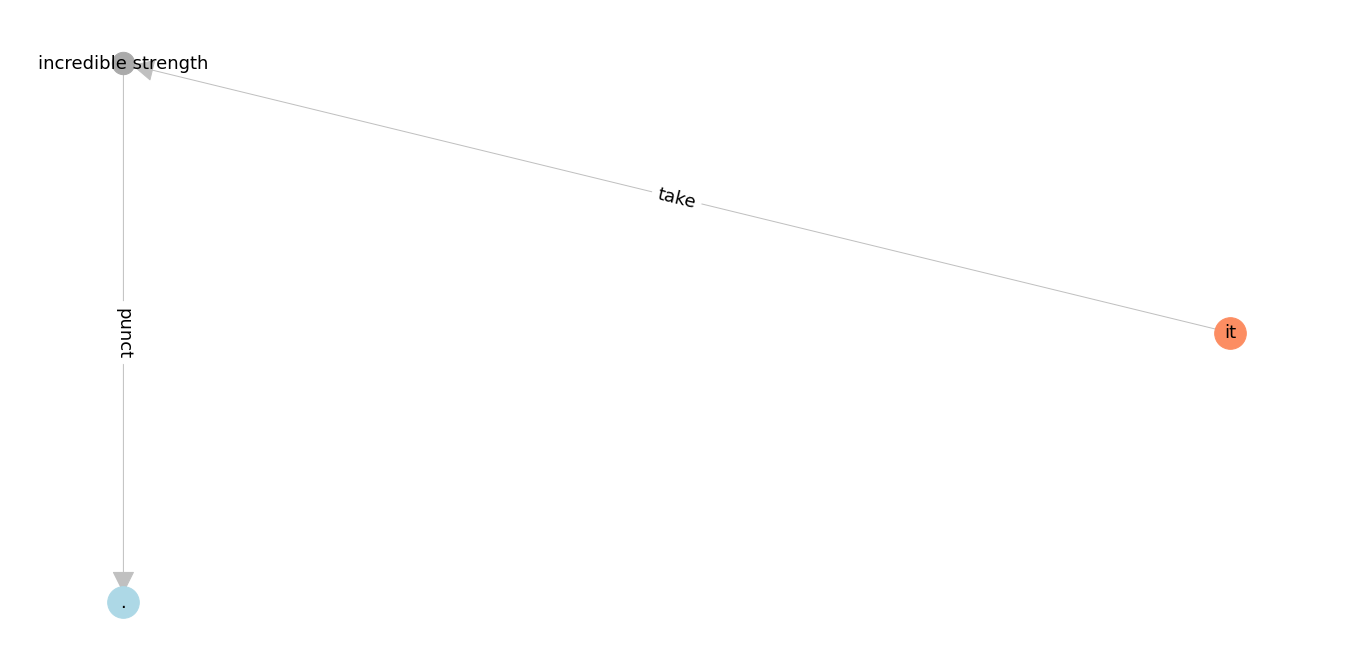

In [88]:
G = build_graph(query)
show_fig(G)

0.0243 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.0225 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.0224 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.0198 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.019 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.0179 Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, A
0.0227 TFW an automatic overnight security update takes the liberty of updating your NVIDIA toolkit (sorry 
0.0167 TFW an automatic overnight security update takes the liberty of updating your NVIDIA toolkit (sorry 
0.0192 Anna think the future of the future will be full of incredible changes and advancements. We will lik
0.0152 Rob be glad you enjoy 

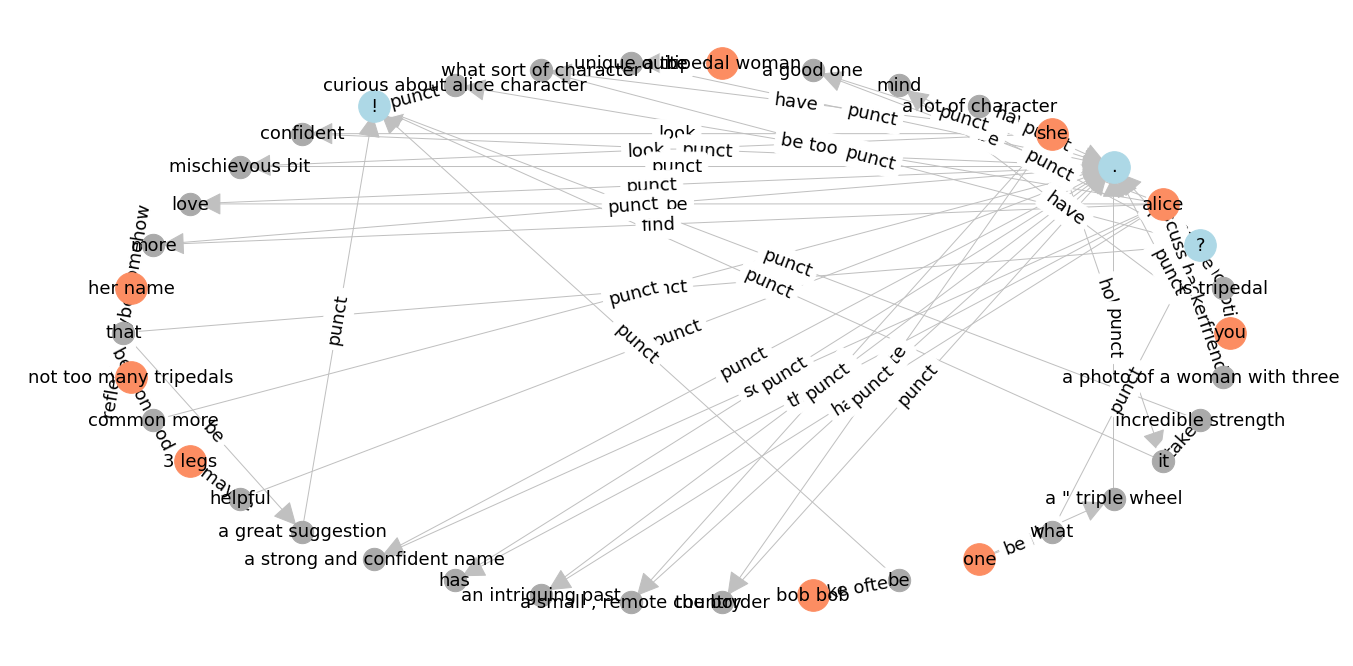

Hi Anna, did you notice that one of your women in the picture is tripedal? Hi hackerfriendly! Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique. It looks like she has a lot of character. What other names starting with M, N, O, S or W did you have in mind? Monica is a good one. hackerfriendly saw a show with a woman named Morticia. A tripedal woman is quite unique, even in the art world. What sort of character does she have? Anna be curious about her character too! She looks confident and composed, but also a bit mischievous. Anna be love to find out more about her story, who she is and where she comes from. Maybe her name could reflect that somehow? Accurately? Not too many tripedals, monopod might be more common. What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profession. That's a great suggestion! Natasha does sound like a strong and confident name that fits her persona

In [89]:
dabest = best_match(G, hits, edge_bias=0.5)
show_fig(load_graph(dabest))
print(dabest['_source']['convo'])

In [90]:
print(dabest['_score'])
Gdb = load_graph(dabest)

8.067378


In [91]:
set([str(e) for e in G.edges(data=True)]).intersection([str(e) for e in Gdb.edges(data=True)])

{"('it', 'incredible strength', {'edge': 'take'})"}

In [92]:
set(G.nodes()).intersection(Gdb.nodes())

{'.', 'incredible strength', 'it'}